In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
from glob import glob

from utils.datasets.foscal.patient import FOSCALPatient
from metrics import compute_segmentation_metrics

from importlib import reload

sns.set_theme()

# Load the data

In [12]:
patients = []
dset_dir = "/data/Datasets/stroke/ISBI_FOSCAL/"
patient_dirs = glob(os.path.join(dset_dir, "*"))
for patient_dir in patient_dirs:
    patient = FOSCALPatient(patient_dir)
    patients.append(patient)

# Visualize some cases

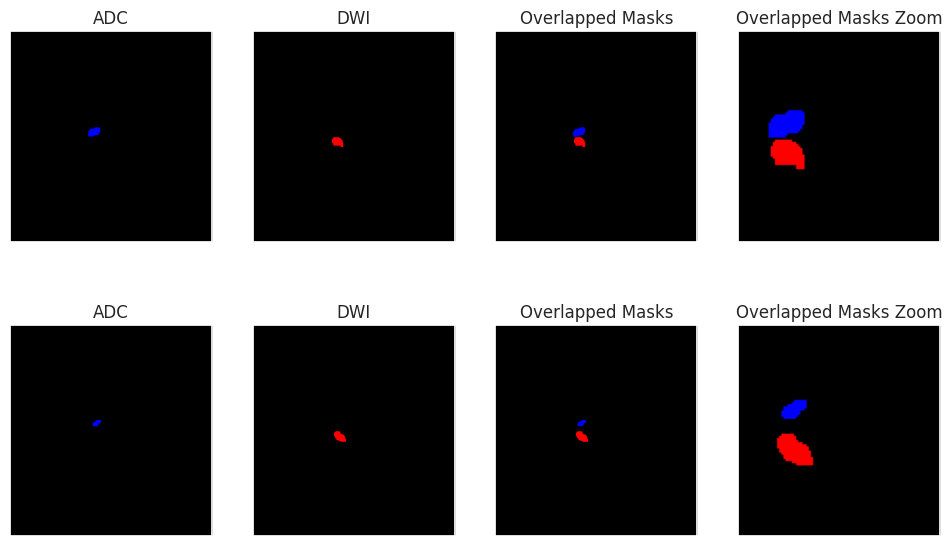

In [48]:
modalities = ["ADC", "DWI"]
normalization = "min_max"
data = patients[0].get_data(modalities=modalities, normalization=normalization)
masks = patients[0].get_mask(modalities=modalities)

suma=masks['ADC'].sum(axis=0)
plots = np.nonzero(suma.sum(axis=0))[0].tolist()

plt.figure(figsize=(12, 7))
N_COLS = 4

for idx, n_plot in enumerate(plots):
    dwi = masks['DWI'][:, :, n_plot]
    adc = masks['ADC'][:, :, n_plot]
    
    red_dwi = np.zeros(shape=(dwi.shape[0], dwi.shape[1], 3))
    blue_adc = np.zeros(shape=(adc.shape[0], adc.shape[1], 3))
    red_dwi[:, :, 0] = dwi[:, :]
    blue_adc[:, :, 2] = adc[:, :]
    
    plt.subplot(len(plots), N_COLS, (idx * N_COLS) + 1)
    plt.imshow(blue_adc, origin='lower')
    plt.xticks([])
    plt.yticks([])
    plt.title('ADC')
    
    plt.subplot(len(plots), N_COLS, (idx * N_COLS) + 2)
    plt.imshow(red_dwi, origin='lower')
    plt.xticks([])
    plt.yticks([])
    plt.title('DWI')
    
    plt.subplot(len(plots), N_COLS, (idx * N_COLS) + 3)
    plt.imshow(blue_adc + red_dwi, origin='lower')
    plt.xticks([])
    plt.yticks([])
    plt.title('Overlapped Masks')
    
    plt.subplot(len(plots), N_COLS, (idx * N_COLS) + 4)
    plt.imshow(blue_adc + red_dwi)
    plt.ylim([int(dwi.shape[0]/3), int(dwi.shape[0]/3) * 2])
    plt.xlim([int(dwi.shape[1]/3), int(dwi.shape[1]/3) * 2])
    plt.xticks([])
    plt.yticks([])
    plt.title('Overlapped Masks Zoom')
    
plt.show()

# Dataset Characterization

In [249]:
def get_masks(radiologists):
    rad_masks = {}
    for rad in radiologists:
        doc_masks = []
        for person in patients:
            masks = person.get_mask(modalities=modalities, radiologist=rad)
            doc_masks.append({'DWI': masks['DWI'], 'ADC': masks['ADC']})

        rad_masks[rad] = doc_masks
        
    return rad_masks

RADIOLOGISTS = ['Daniel', 'Andres']
masks = get_masks(RADIOLOGISTS)

### Expected Results:
 - How many samples?
 - How many actually marked?
 - 
 
Show the metrics between the masks
Show percentages plots of the overall data and per Doctor
Group patients by dice score and propose a possible reason

### Overall Dataset

In [83]:
# How many samples?
# Amount of images per patient per measure (ADC OR DWI)
# Amount of masks per patient per measuere (ADC OR DWI)
# Amount of masks marked by both vs masks marked only for 1 doc

masks_info = []
for rad_idx, rad in enumerate(masks.keys()):
    patient_list = masks[rad]
    for p_idx, patient in enumerate(patient_list):
        
        # Fills the patient info
        if rad_idx > 0:
            row = masks_info[p_idx]
        else: 
            row = {}
            
        for measure_type, measure in patient.items():
            marked = np.array(measure.sum(axis=0).sum(axis=0) != 0).sum()
            total = measure.shape[-1]
            row[f'slices_per_measure'] = total
            row[f'Rad{rad_idx}_{measure_type}_marked'] = marked
        
        if rad_idx == 0:
            masks_info.append(row)
        else:
            masks_info[p_idx] = row

info_dataset = pd.DataFrame(data = masks_info)
info_dataset.index.names = ['Patient']
info_dataset

,slices_per_measure,Rad0_DWI_marked,Rad0_ADC_marked,Rad1_DWI_marked,Rad1_ADC_marked
Patient,,,,,
0,20,2,2,2,2
1,25,1,1,3,1
2,20,7,6,8,6
3,26,8,4,12,6
4,26,7,5,5,4
5,23,5,2,8,7
6,24,6,2,4,3
7,26,3,3,2,3
8,24,8,4,9,5


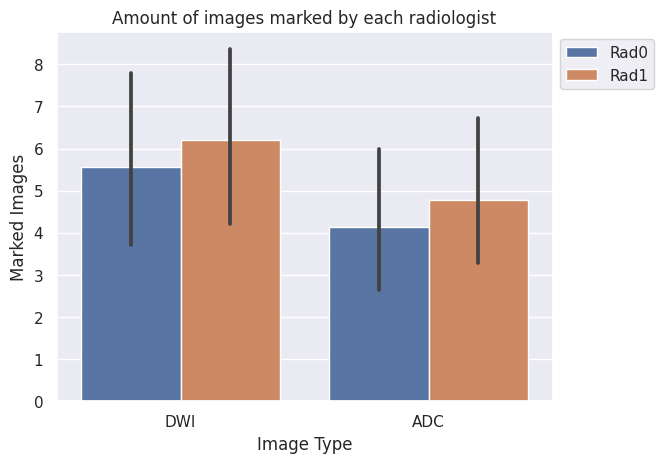

In [241]:
y_ax_name = 'Marked Images'
grouped_info = info_dataset.melt(value_vars=[x for x in info_dataset.columns if 'slices' not in x])
grouped_info['radiologist']=grouped_info['variable'].apply(lambda x: x.split('_')[0])
grouped_info['variable'] = grouped_info['variable'].apply(lambda x: x.split('_')[1])
grouped_info.columns = ['Image Type', y_ax_name, 'Radiologist']

sns.barplot(data=grouped_info, y=y_ax_name, x='Image Type', hue='Radiologist')#, palette=['purple', 'steelblue'])
plt.title('Amount of images marked by each radiologist')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

In [97]:
# Disagreement between Radiologists
diff_rads = pd.DataFrame(
    data = {
        'slices_per_measure': info_dataset['slices_per_measure'],
        'Abs_Diff_DWI': np.abs(info_dataset['Rad0_DWI_marked'] - info_dataset['Rad1_DWI_marked']),
        'Abs_Diff_ADC': np.abs(info_dataset['Rad0_ADC_marked'] - info_dataset['Rad1_ADC_marked'])
    })
diff_rads

,slices_per_measure,Abs_Diff_DWI,Abs_Diff_ADC
Patient,,,
0,20,0,0
1,25,2,0
2,20,1,0
3,26,4,2
4,26,2,1
5,23,3,5
6,24,2,1
7,26,1,0
8,24,1,1


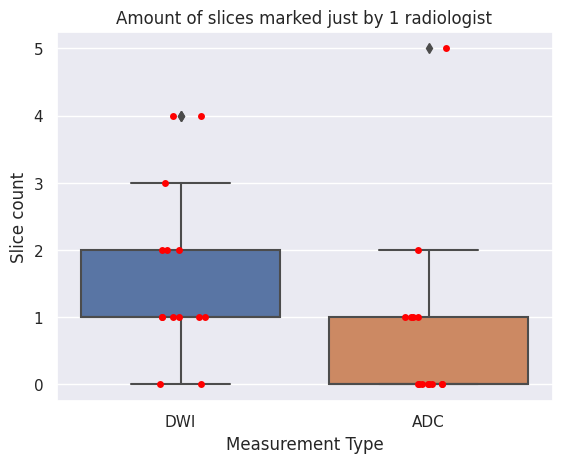

In [227]:
y_ax_name = 'Slice count'
grouped_diff_measure = diff_rads.melt(value_vars=[x for x in diff_rads.columns if 'slices' not in x])
grouped_diff_measure['variable'] = grouped_diff_measure['variable'].apply(lambda x: x.split('_')[-1])
grouped_diff_measure.columns = ['Measurement Type', y_ax_name]

#sns.barplot(data=grouped_diff_measure, y=y_ax_name, x='Measurement Type')
sns.stripplot(data=grouped_diff_measure, y=y_ax_name, x='Measurement Type', color ='red')
sns.boxplot(data=grouped_diff_measure, y=y_ax_name, x='Measurement Type')
plt.title('Amount of slices marked just by 1 radiologist')
plt.show()

In [184]:
# Disagreement between Masks for the same radiologist
diff_masks = pd.DataFrame(
    data = {
        'slices_per_measure': info_dataset['slices_per_measure'],
        'Abs_Diff_Rad0': np.abs(info_dataset['Rad0_DWI_marked'] - info_dataset['Rad0_ADC_marked']),
        'Abs_Diff_Rad1': np.abs(info_dataset['Rad1_DWI_marked'] - info_dataset['Rad1_ADC_marked'])
    })
diff_masks

,slices_per_measure,Abs_Diff_Rad0,Abs_Diff_Rad1
Patient,,,
0,20,0,0
1,25,0,2
2,20,1,2
3,26,4,6
4,26,2,1
5,23,3,1
6,24,4,1
7,26,0,1
8,24,4,4


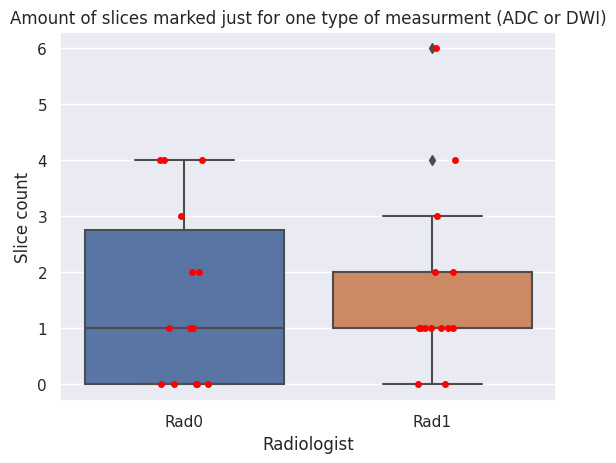

In [226]:
y_ax_name = 'Slice count'
grouped_diff_rad = diff_masks.melt(value_vars=[x for x in diff_masks.columns if 'slices' not in x])
grouped_diff_rad['variable'] = grouped_diff_rad['variable'].apply(lambda x: x.split('_')[-1])
grouped_diff_rad.columns = ['Radiologist', y_ax_name]

#sns.barplot(data=grouped_diff_rad, y=y_ax_name, x='Radiologist')
sns.boxplot(data=grouped_diff_rad, y=y_ax_name, x='Radiologist')
sns.stripplot(data=grouped_diff_rad, y=y_ax_name, x='Radiologist', color='red')
plt.title('Amount of slices marked just for one type of measurment (ADC or DWI)')
plt.show()

In [100]:
radiologists = ['Daniel', 'Andres']
rad_metrics = {}
for rad in radiologists:
    rad_scores = []
    for person in patients:
        masks = person.get_mask(modalities=modalities, radiologist=rad)
        rad_scores.append(compute_segmentation_metrics(masks['DWI'], masks['ADC']))
    
    rad_metrics[rad] = pd.DataFrame(data=rad_scores)
    rad_metrics[rad].index.names=['Patient']
rad_metrics['Daniel']

,sens,spec,ppv,npv,dsc,avd,hd
Patient,,,,,,,
0,0.000000,0.999857,0.000000,0.999800,0.000000,0.333895,19.339080
1,0.000000,0.999986,0.000000,0.999999,0.000000,1.833333,187.480666
2,0.609300,0.999832,0.874350,0.999250,0.718150,0.357295,48.083261
3,0.267274,0.999728,0.731439,0.997969,0.391494,0.929525,15.556349
4,0.332026,0.999902,0.803084,0.999200,0.469814,0.829979,12.688578
5,0.000000,0.999816,0.000000,0.998006,0.000000,1.662964,88.368546
6,0.000000,0.999865,0.000000,0.998689,0.000000,1.627089,100.588270
7,0.000000,0.999857,0.000000,0.999826,0.000000,0.196660,50.950957
8,0.303806,0.999955,0.867041,0.999325,0.449954,0.962099,23.323808


### 2. Descriptive Statistics

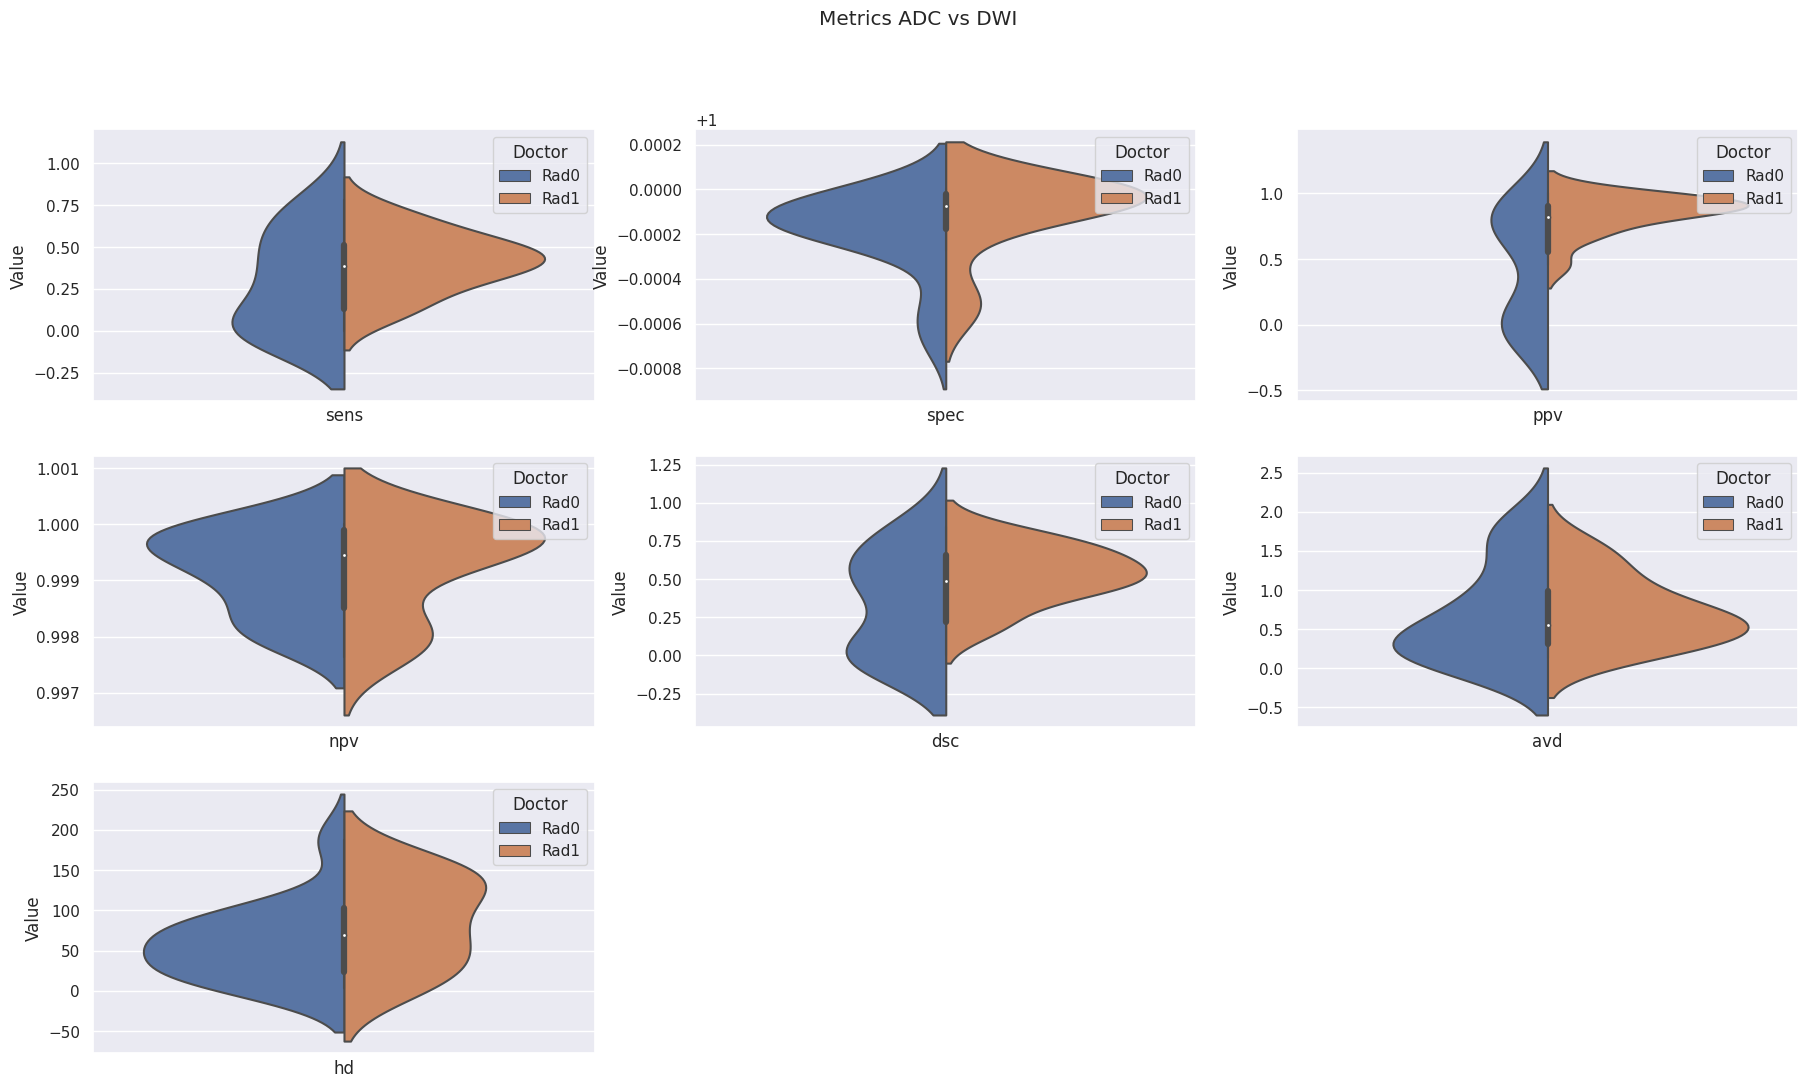

In [129]:
metricas = rad_metrics['Andres'].columns
stat_to_plot = {}
fig = plt.figure(figsize=(22, 12))
fig.suptitle('Metrics ADC vs DWI')

for idx, stat in enumerate(metricas):
    temp = pd.DataFrame(
        data = {rad: rad_metrics[rad][stat] for rad in RADIOLOGISTS})
    
    stat_to_plot[stat] = temp.melt()
    stat_to_plot[stat].columns = ['Doctor', 'Value']
    stat_to_plot[stat]['Doctor'].replace(
        RADIOLOGISTS, [f'Rad{x}' for x in range(len(RADIOLOGISTS))], 
        inplace=True)
    stat_to_plot[stat][stat] = idx
    
    plt.subplot(3, 3, idx + 1)
    sns.violinplot(data=stat_to_plot[stat], y='Value', hue='Doctor', x=stat, split=True)
    #plt.title(stat)
    plt.xticks([])

plt.show()

In [270]:
def plot_marked_masks(patient, masks_per_rad):
    """
    Plots overlapping masks for a given patient
    """
    measurement_types = ['ADC', 'DWI']
    idx_marked = {meas: [] for meas in measurement_types}
    for rad in masks_per_rad.keys():
        marks = masks_per_rad[rad][patient]
        for meas_type in measurement_types:
            idx_marked[meas_type] += [x for x in np.nonzero(marks[meas_type].sum(axis=0).sum(axis=0))[0] if x not in idx_marked[meas_type]]
            
    
    # Plots the images
    plt.figure(figsize=(20, 20))
    max_num_marsk = np.max([x ])
    for 

plot_marked_masks(1, masks)



{'ADC': [14, 6], 'DWI': [20, 1, 6]}
